In [9]:
from dataset import DeezerDataset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import seaborn as sns 
sns.set_style("darkgrid")

# Background

In this project, we aim to explore the Deezer Europe social network (https://snap.stanford.edu/data/feather-deezer-social.html). The network consists of Deezer users which was collected from the public API in March 2020. Nodes are Deezer users from European countries and edges are mutual follower relationships between them. The vertex features are extracted based on the artists liked by the users. The task related to the graph is binary node classification - one has to predict the gender of users. This target feature was derived from the name field for each user.

There are 28281 users and 31241 artists in this dataset, resulting in a ~28000 x 31000 feature matrix.

The github repository of this project can be found at https://github.com/Weijiang-Xiong/NML23-Project.

# Progress

* First, we explored various aspects of the network, evaluated its degree distribution and network properties. This step is to help us better understand the network in general.
* Second, we completed various **data preprocessing and node embedding** pipelines. Since the original dataset come in json format, we first transformed it into dataset class compatible with PyG or networkx format. We implemented multiple node embedding techniques, including node2vec, feather or using the raw features.
* Third, we built a baseline model of graph convolutional neural network for the binary node classification task. 

## Part 1: Network Exploration
In this section, we aim to explore various properties of the network to help us better understand its behavior.

First, we load the graph as a networkx graph based on a custom class called DeezerDataset we developed.

In [11]:
# Load DeezerDataset as a networkx graph
dataset = DeezerDataset("./data/", from_raw=True, method=None, save_data=True)
G = dataset[0]

We now plot its degree distribution.

The 10 highest degrees in this graph [172, 152, 145, 117, 112, 110, 96, 94, 93, 92]


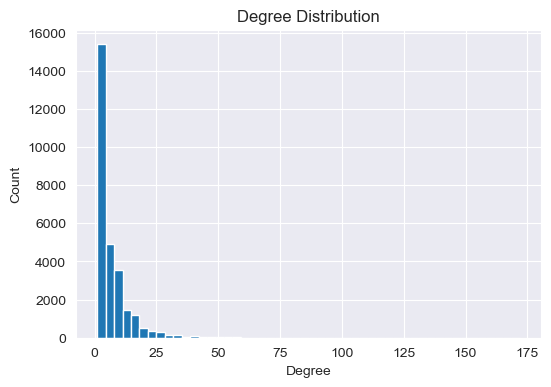

In [12]:
# degree distribution
degrees = sorted([G.degree(node) for node in G.nodes()])
print("The 10 highest degrees in this graph {}".format(degrees[-10:][::-1]))

plt.figure(figsize=(6,4))
plt.hist(degrees, bins=50)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

The degree distribution can be fitted with a power law distribution:

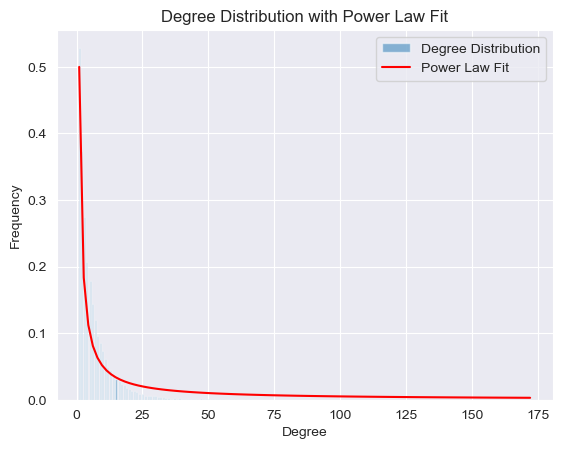

In [8]:
def power_law(k, alpha):
    '''
    Power law distribution y = k * x ^ alpha.
    '''
    return k * x ** alpha

x = np.linspace(min(degrees), max(degrees), num=100)
y = power_law(0.5, -1)

# Plot the degree distribution and the fitted power law curve
plt.hist(degrees, bins='auto', alpha=0.5, density=True, label='Degree Distribution')
plt.plot(x, y, 'r-', label='Power Law Fit')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution with Power Law Fit')
plt.legend()
plt.savefig('figs/DegreeDistributionFit.png')

# Display the plot
plt.show()

From the degree distribution figure, it can be seen that in the network most nodes have low connections, but different from scale-free network, there are no nodes with relatively higher connections. We can calulate its shortest path length and average clustering:

In [5]:
print(f'Average shortest path length is {nx.average_shortest_path_length(G)}')
print(f'Diameter {nx.diameter(G)}')
print(f'Average clustering is {nx.average_clustering(G)}')
print(f'Network Density {nx.density(G)}')
print(f'Number of nodes {G.number_of_nodes()}')
print(f'Number of edges {G.number_of_edges()}')

Average shortest path length is 6.449804500370024
Diameter 21
Average clustering is 0.14115987333165492
Network Density 0.00023194184729358083
Number of nodes 28281
Number of edges 92752


The network at hand has low clustering and relatilvely high average shortest path length, thus do not entirely follow the scale-free network model. We can use a Barabasi-Albert network model to simulate the network:

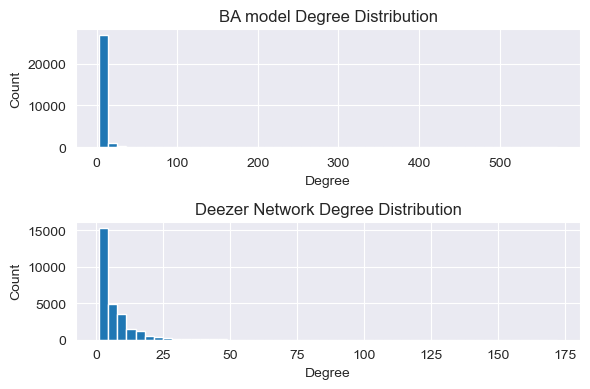

In [17]:
q = np.round(np.mean(degrees)/2).astype(np.int32)
G_ba = nx.barabasi_albert_graph(G.number_of_nodes(), q)

degrees_ba = [G_ba.degree(node) for node in G_ba.nodes()]

plt.figure(figsize=(6,4))

plt.subplot(2,1,1)
plt.hist(degrees_ba, bins=50)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('BA model Degree Distribution')
plt.grid(True)
# plt.xlim(0, 200)
# plt.ylim(0, 2000)

plt.subplot(2,1,2)
plt.hist(degrees, bins=50)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Deezer Network Degree Distribution')
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/BA.png')

plt.show()

In [7]:
from itertools import chain
from collections import Counter

liked_artists = [attr['features'] for n, attr in G.nodes(data=True)]
artists_followers = dict(Counter(chain.from_iterable(liked_artists)))
artists_followers = sorted(artists_followers.items(), key= lambda x: x[1]) # sort according to value

The 10 most popular artists and their number of followers in format (artist, #followers)
[(505, 4693), (12, 3777), (251, 3401), (675, 3376), (21342, 3311), (87, 3013), (832, 2979), (108, 2747), (174, 2714), (398, 2634)]


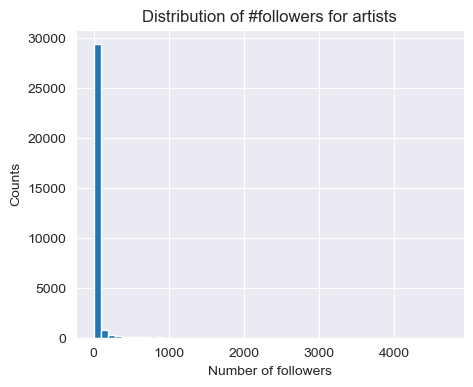

In [8]:
print("The 10 most popular artists and their number of followers in format (artist, #followers)")
print(artists_followers[-10:][::-1])

fig, ax = plt.subplots(figsize=(5,4))
ax.hist(np.array(artists_followers)[:, 1], bins=50)
ax.set_title("Distribution of #followers for artists")
ax.set_xlabel("Number of followers")
ax.set_ylabel("Counts")
plt.show()

Next, we perform a label anlysis for the classification task.

In [9]:
# Load dataset as a pyg graph
Data = DeezerDataset("./data/", from_raw=False, save_data=False)

In [10]:
print(f'Proportion of gender division is {sum(Data.y) / len(Data.y)}')

Proportion of gender division is 0.44333651661872864


Thus we can see that labels in this classification task are basically balanced.

## Part 2: Model training

In this part we train a baseline GCN model on the network for user gender classification. We use 80% of the nodes for training, 10% for validation and test respectively.

The following command will train a GCN model with hidden dimension 64 for 200 epochs/iterations, and the learning rate and weight decay in the optimizer are set to 0.0001 and 0.001 respectively.

By default, the features are transformed to 128 dimensions using truncated SVD.

In [11]:
!python train_net.py --model gcn --hid-dim 64 --max-epoch 200 --learning-rate 0.0001 --weight-decay 0.001

Using these configurations
Namespace(data_root='./data', from_raw=False, method=None, save_data=False, model='gcn', hid_dim=64, max_epoch=200, learning_rate=0.0001, weight_decay=0.001, metric='auc')

Device:  cuda
Using model class GCN
Detailed Model Definition:
GCN(
  (graphconv1): GCNConv(128, 64)
  (graphconv2): GCNConv(64, 64)
  (graphconv3): GCNConv(64, 2)
)
Epoch: 000, Train Loss: 0.751, Val Score: 0.462
Epoch: 010, Train Loss: 0.729, Val Score: 0.466
Epoch: 020, Train Loss: 0.716, Val Score: 0.478
Epoch: 030, Train Loss: 0.705, Val Score: 0.496
Epoch: 040, Train Loss: 0.700, Val Score: 0.512
Epoch: 050, Train Loss: 0.696, Val Score: 0.526
Epoch: 060, Train Loss: 0.692, Val Score: 0.536
Epoch: 070, Train Loss: 0.693, Val Score: 0.546
Epoch: 080, Train Loss: 0.691, Val Score: 0.554
Epoch: 090, Train Loss: 0.689, Val Score: 0.562
Epoch: 100, Train Loss: 0.689, Val Score: 0.569
Epoch: 110, Train Loss: 0.689, Val Score: 0.574
Epoch: 120, Train Loss: 0.687, Val Score: 0.579
Epoch: 130

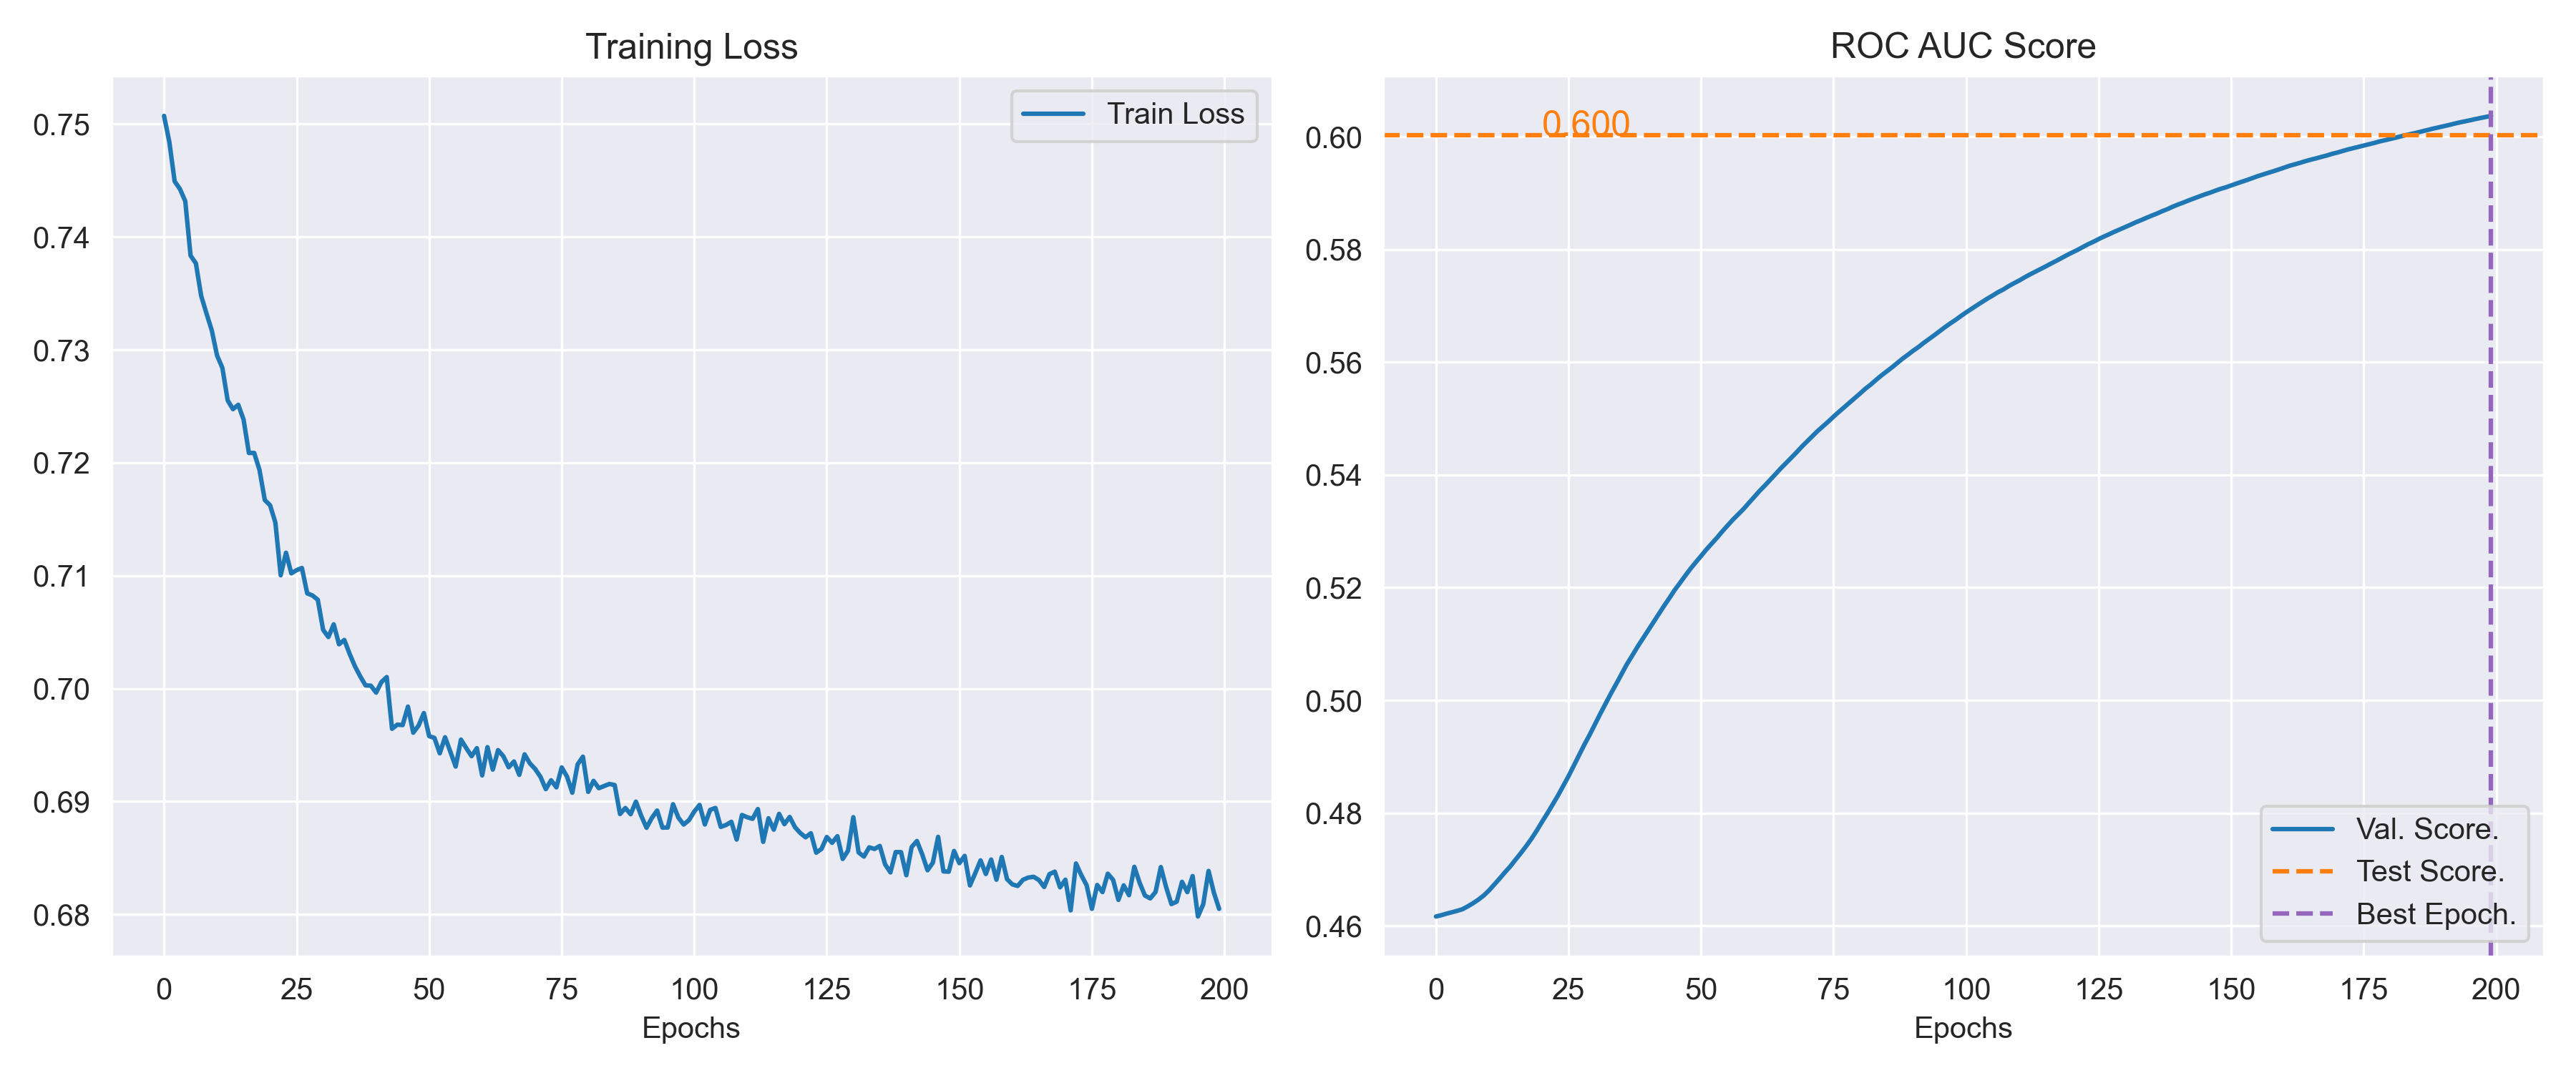

In [13]:
from IPython.display import Image, display
display(Image(filename='figs/training_log_preset_gcn.png'))